In [1]:
import json
from cgr.filepaths import filepaths
from collections import defaultdict
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
from cgr.draw import draw_molecule
from cgr.cheminfo import (
    MorganFingerprinter,
    extract_subgraph,
    resolve_bit_collisions,
    is_subgraph_saturated,
    has_subgraph_only_carbons
)

In [2]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


In [3]:
max_hops = 3
vec_len = 2**12
mfper = MorganFingerprinter(radius=max_hops, length=vec_len, allocate_ao=True)
rc_dist_ub = None

data = defaultdict(list)
for rid, rxn in decarb.items():
    rc = rxn['reaction_center'][0]
    smiles = rxn['smarts'].split('>>')[0]
    mol = Chem.MolFromSmiles(smiles)
    _ = mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub)
    bim = mfper.bit_info_map


    for bit_idx, examples in bim.items():
        for (central_aidx, radius) in examples:
            data['feature_id'].append(bit_idx)
            data['sample_id'].append(rid)
            data['mol'].append(mol)

            sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, central_aidx, radius)

            data['sub_idxs'].append(sub_idxs)
            data['sub_smi'].append(sub_smi)
            data['sub_mol'].append(sub_mol)
            data['saturated'].append(is_subgraph_saturated(mol, rc, sub_idxs))
            data['only_carbon'].append(has_subgraph_only_carbons(mol, rc, sub_idxs))

raw_subgraphs = pd.DataFrame(data)

examples, embeddings = resolve_bit_collisions(raw_subgraphs, vec_len)

embed_mat = np.vstack(embeddings['embedding'])
p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]

examples['accept'] = ~(examples['saturated'] & examples['only_carbon'])
examples['p1'] = 0.0
for ftid in examples['feature_id'].unique():
    examples.loc[examples['feature_id'] == ftid, 'p1'] = p1[ftid]

features = examples.groupby(by='feature_id').aggregate('first')[['sub_smi', 'saturated', 'only_carbon', 'accept', 'p1']]
examples.set_index('feature_id', inplace=True)
examples.drop(columns=['saturated', 'only_carbon', 'accept', 'p1'], inplace=True)

In [4]:
features.head()

,sub_smi,saturated,only_carbon,accept,p1
feature_id,,,,,
0,COP(=O)(O)OP,False,False,True,0.011628
1,CC,True,True,False,0.011628
2,NCCCC(N)C(=O)O,True,False,True,0.011628
3,cc(C)cc(c)O,False,False,True,0.011628
4,ccc,False,True,True,0.023256


In [5]:
examples.head()

,sample_id,mol,sub_idxs,sub_smi,sub_mol
feature_id,,,,,
1,3306,<rdkit.Chem.rdchem.Mol object at 0x7f046c0403c0>,"(11, 12)",CC,<rdkit.Chem.rdchem.Mol object at 0x7f046c048c80>
3,10549,<rdkit.Chem.rdchem.Mol object at 0x7f046c0a9d20>,"(3, 5, 7, 8, 9, 10, 11)",cc(C)cc(c)O,<rdkit.Chem.rdchem.Mol object at 0x7f046c0a9e00>
4,5026,<rdkit.Chem.rdchem.Mol object at 0x7f046c062f10>,"(11, 12, 13)",ccc,<rdkit.Chem.rdchem.Mol object at 0x7f046c063140>
4,7342,<rdkit.Chem.rdchem.Mol object at 0x7f046c08a570>,"(8, 9, 10)",ccc,<rdkit.Chem.rdchem.Mol object at 0x7f046c08a5e0>
7,3306,<rdkit.Chem.rdchem.Mol object at 0x7f046c0403c0>,"(35, 36, 37, 19, 20, 21, 22, 23, 24, 25)",CCOC(COC)COP,<rdkit.Chem.rdchem.Mol object at 0x7f046c048cf0>


Visualize features

Probability: 0.41


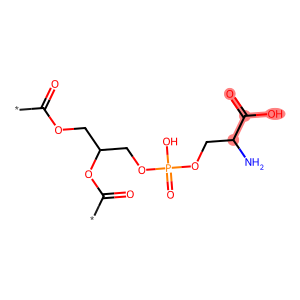

--------------------------------------------------
Probability: 0.34


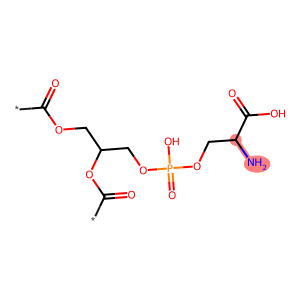

--------------------------------------------------
Probability: 0.34


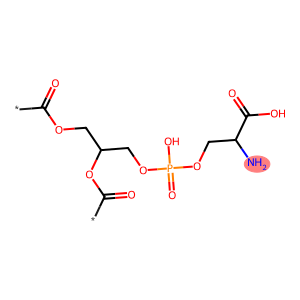

--------------------------------------------------
Probability: 0.33


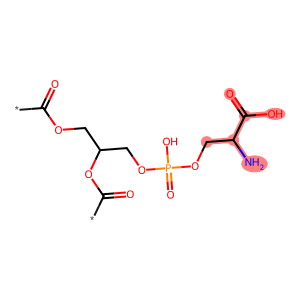

--------------------------------------------------
Probability: 0.33


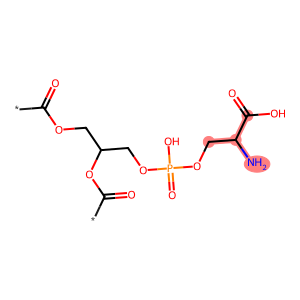

--------------------------------------------------
Probability: 0.22


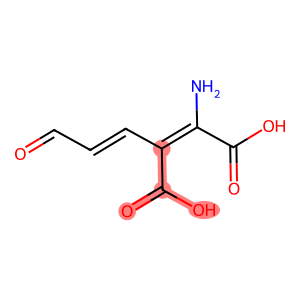

--------------------------------------------------
Probability: 0.21


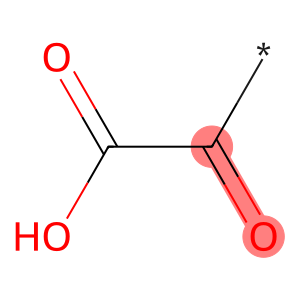

--------------------------------------------------
Probability: 0.21


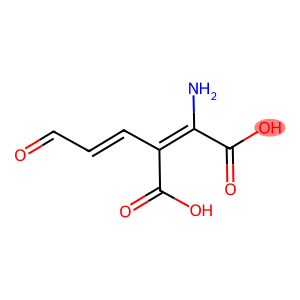

--------------------------------------------------
Probability: 0.21


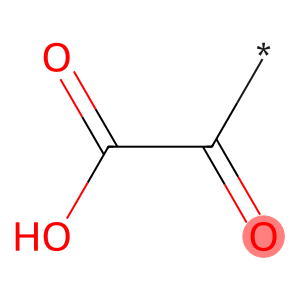

--------------------------------------------------
Probability: 0.17


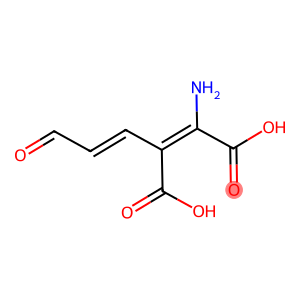

--------------------------------------------------
Probability: 0.15


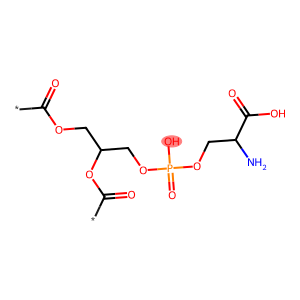

--------------------------------------------------
Probability: 0.15


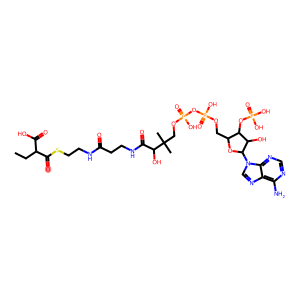

--------------------------------------------------


In [7]:
topk = 10
sort_by = 'p1'
features.sort_values(by=sort_by, inplace=True, ascending=False)
accepted = features[(features['p1'] < 1) & features['accept']]
accepted.head(50)

for i, (ftid, row) in enumerate(accepted.iterrows()):
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    print(f"Probability: {row['p1']:.2f}")
    display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)
    if i > topk:
        break